In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 25 unqiue cards
Generated 300 cardpairs
-- 100 cardpairs with shared concept
-- 200 cardpairs without shared concept
[(0, 200), (1, 100)]
Total number of matches =  500
Number of shared concepts per match =  [(1, 500)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 7000), (0.002, 500)]

In [5]:
np.sum(count_table)

500.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 9
xy_div_xyind_rank= 9


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

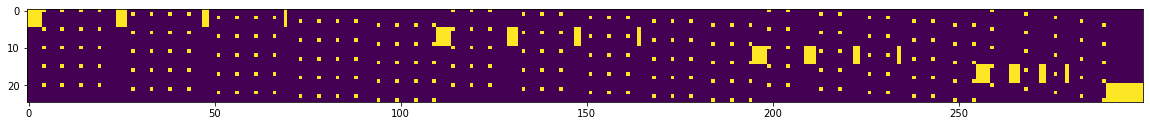

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

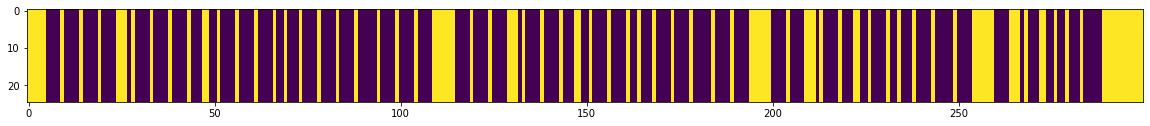

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

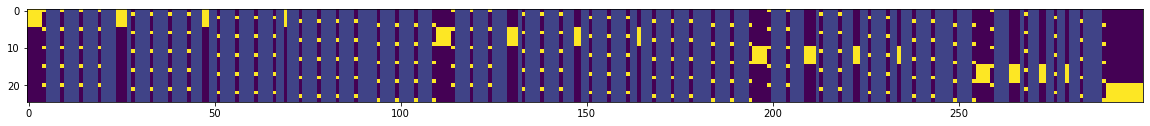

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

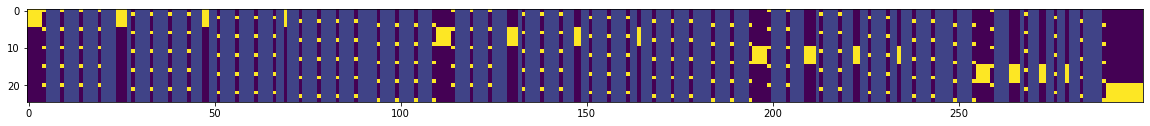

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999997, 3800),
 (2.5e-97, 1920),
 (0.9999999999999993, 1000),
 (5.0, 380),
 (0.9999999999999998, 200),
 (4.999999999999999, 100),
 (2.5000000000000003e-97, 80),
 (5.000000000000001, 20)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # classifier
    if hparams['classifier_nonlinearity'] == 'ReLU':
        classifier_non_linearity = nn.ReLU
    elif hparams['classifier_nonlinearity'] == 'Sigmoid':
        classifier_non_linearity = nn.Sigmoid
    else:
        raise ValueError('Unaccepted choice of nonlinearity')
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict(
                make_classifier(
                    scale_down_factor=hparams['classifier_layer_scaledown_factor'], 
                    d_model=hparams['d_model'],
                    non_linearity_class = classifier_non_linearity,
                )
            )
        ) if not hparams['dotproduct_bottleneck'] else None, 
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
def make_classifier(scale_down_factor, d_model, non_linearity_class):
    '''
    scale_down_factor: list e.g. [2,2,4]
    '''
    layer_lst = []
    last_dim = 2*d_model
    for i in range(len(scale_down_factor)):
        new_dim = int(2*d_model / scale_down_factor[i])
        layer_lst.append(('linear{}'.format(i), nn.Linear(last_dim, new_dim)))
        layer_lst.append(('Nonlinear{}'.format(i), non_linearity_class()))
        last_dim = new_dim
    layer_lst.append(('linear-out', nn.Linear(last_dim, 1)))
    
    return layer_lst

make_classifier([2,2,4], 48, nn.ReLU)

[('linear0', Linear(in_features=96, out_features=48, bias=True)),
 ('Nonlinear0', ReLU()),
 ('linear1', Linear(in_features=48, out_features=48, bias=True)),
 ('Nonlinear1', ReLU()),
 ('linear2', Linear(in_features=48, out_features=24, bias=True)),
 ('Nonlinear2', ReLU()),
 ('linear-out', Linear(in_features=24, out_features=1, bias=True))]

In [18]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [19]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        print(classifier)
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [20]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [21]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [22]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [23]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # classifier
    'classifier_nonlinearity': 'ReLU', # ReLU, Sigmoid
    'classifier_layer_scaledown_factor': [1,2], 
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 8,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':False,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;{}{}ClassifierLayers'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2), str(hparams['classifier_layer_scaledown_factor']), hparams['classifier_nonlinearity'])
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


Sequential(
  (linear0): Linear(in_features=16, out_features=16, bias=True)
  (Nonlinear0): ReLU()
  (linear1): Linear(in_features=16, out_features=8, bias=True)
  (Nonlinear1): ReLU()
  (linear-out): Linear(in_features=8, out_features=1, bias=True)
)
   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 3.0 K 
1  | model.inp_query_layer                        | Sequential         | 2.4 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.4 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.4 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 200   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 200   
7  | model.inp_key_lay

## Run Training

In [24]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-24-86fefc262d20>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 3.0 K 
1  | model.inp_query_layer                        | Sequential         | 2.4 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.4 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.4 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 200   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 200   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 200   
8  | model.classifier                             | Sequential         | 417   
9  | model.classifier.linear0                     | Linear             | 272   
10 | model.classifier.Nonlinear0 

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.23it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 11.18it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  9.30it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 2

Epoch 44: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████| 2/2 [00:00<00:00, 19.68it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=621, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████| 2/2 [00:00<00:00, 18.54it/s, loss=620, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s, loss=620, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=620, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 51: 100%|██████████| 2/2 [00:00<00:00, 18.05it/s, loss=620, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=620, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 53: 100%|████

Epoch 87: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 90:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 91: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 92: 100%|██████████| 2/2 [00:00<00:00, 17.78it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 93: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 94:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=619, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 96:  50%|████

Epoch 129: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=615, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 130: 100%|██████████| 2/2 [00:00<00:00, 18.86it/s, loss=615, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00, 12.65it/s, loss=615, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 132: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=614, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 133: 100%|██████████| 2/2 [00:00<00:00, 18.08it/s, loss=614, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 134: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=614, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=613, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 136: 100%|██████████| 2/2 [00:00<00:00, 19.43it/s, loss=613, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s, loss=613, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 138:

Epoch 172: 100%|██████████| 2/2 [00:00<00:00, 15.37it/s, loss=599, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 173: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=599, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 174: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=598, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 175: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s, loss=598, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 176: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=597, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=596, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 178: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=596, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 179: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=595, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=595, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 181:

Epoch 214:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=571, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 215: 100%|██████████| 2/2 [00:00<00:00, 18.58it/s, loss=570, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 216: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=570, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 217: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s, loss=569, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=568, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=567, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 220: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=567, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 221: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=566, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 222: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=565, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 223:

Epoch 257: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=538, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 258: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s, loss=537, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 259: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s, loss=536, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 260: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=535, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 261: 100%|██████████| 2/2 [00:00<00:00, 18.82it/s, loss=534, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 262: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=534, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 263: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=533, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=532, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 265: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=532, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 266:

Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s, loss=510, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 300: 100%|██████████| 2/2 [00:00<00:00, 17.72it/s, loss=509, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 301: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=508, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 302: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s, loss=507, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 303: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=506, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=506, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 305: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=506, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 306: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=505, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 307: 100%|██████████| 2/2 [00:00<00:00, 18.49it/s, loss=505, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 308:

Epoch 342: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=486, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 343: 100%|██████████| 2/2 [00:00<00:00, 17.71it/s, loss=487, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 344: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=486, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 345: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s, loss=485, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 346: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=485, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 347: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s, loss=485, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 348: 100%|██████████| 2/2 [00:00<00:00, 17.10it/s, loss=484, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 349: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s, loss=483, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=483, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 351:

Epoch 384: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s, loss=470, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 385: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=469, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 386: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s, loss=468, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 387: 100%|██████████| 2/2 [00:00<00:00, 18.76it/s, loss=468, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 388: 100%|██████████| 2/2 [00:00<00:00, 18.37it/s, loss=467, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 389: 100%|██████████| 2/2 [00:00<00:00, 18.09it/s, loss=467, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=466, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 391: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=467, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 392: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s, loss=466, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 393:

Epoch 427: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=456, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 428: 100%|██████████| 2/2 [00:00<00:00, 18.69it/s, loss=456, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 429: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=455, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 430: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s, loss=455, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 431: 100%|██████████| 2/2 [00:00<00:00, 16.18it/s, loss=455, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 432: 100%|██████████| 2/2 [00:00<00:00, 18.24it/s, loss=455, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 433: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=454, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 434:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=454, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 435: 100%|██████████| 2/2 [00:00<00:00, 17.38it/s, loss=453, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 436:

Epoch 469: 100%|██████████| 2/2 [00:00<00:00, 13.34it/s, loss=445, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 470: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=445, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 471: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 472: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 473: 100%|██████████| 2/2 [00:00<00:00, 16.43it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 474: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 475: 100%|██████████| 2/2 [00:00<00:00, 17.36it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 476: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 477: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s, loss=444, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 478:

Epoch 511: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=440, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 512: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=439, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 513:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=439, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 514: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=439, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 515: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=438, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 516: 100%|██████████| 2/2 [00:00<00:00, 17.40it/s, loss=437, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 517: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=437, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 518: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=437, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 519: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=437, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 520:

Epoch 553: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=436, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 554: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=436, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 555: 100%|██████████| 2/2 [00:00<00:00, 15.76it/s, loss=436, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 556: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s, loss=435, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 557: 100%|██████████| 2/2 [00:00<00:00, 17.35it/s, loss=435, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 558: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=435, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 559:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=434, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 560: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=434, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 561: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=434, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 562:

Validating: 0it [00:00, ?it/s]
Epoch 595: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=432, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 596: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 597: 100%|██████████| 2/2 [00:00<00:00, 18.45it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 598: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s, loss=432, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 600: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 601: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 602: 100%|██████████| 2/2 [00:00<00:00, 18.56it/s, loss=431, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 603: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s, loss=431, v_num=y1rw]
Validating

Epoch 636: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 637: 100%|██████████| 2/2 [00:00<00:00, 18.55it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 638: 100%|██████████| 2/2 [00:00<00:00, 15.26it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 639: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 640: 100%|██████████| 2/2 [00:00<00:00, 17.82it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 641: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 642: 100%|██████████| 2/2 [00:00<00:00, 15.60it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 643: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 644: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 645:

Validating: 0it [00:00, ?it/s]
Epoch 678: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 679: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 680: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 681: 100%|██████████| 2/2 [00:00<00:00, 19.10it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 682: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 683: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 684: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 685: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=428, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 686: 100%|██████████| 2/2 [00:00<00:00, 18.08it/s, loss=427, v_num=y1rw]
Validating

Epoch 719: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 720: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 721: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 722: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 723: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 724: 100%|██████████| 2/2 [00:00<00:00, 18.69it/s, loss=426, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 725:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s, loss=426, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 726: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=427, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 727: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s, loss=426, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 728:

Validating: 0it [00:00, ?it/s]
Epoch 761: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 762: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 763: 100%|██████████| 2/2 [00:00<00:00, 18.99it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 764: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 765: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 766: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 767: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 768: 100%|██████████| 2/2 [00:00<00:00, 17.63it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 769: 100%|██████████| 2/2 [00:00<00:00, 17.59it/s, loss=424, v_num=y1rw]
Validating

Epoch 802: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 803: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 805: 100%|██████████| 2/2 [00:00<00:00, 17.17it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 806: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 808: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 809: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 810: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=425, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 811:

Epoch 844: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 845: 100%|██████████| 2/2 [00:00<00:00, 16.05it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 846:  50%|█████     | 1/2 [00:00<00:00, 11.07it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 847: 100%|██████████| 2/2 [00:00<00:00, 11.06it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 848: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 849: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 850: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 851: 100%|██████████| 2/2 [00:00<00:00, 18.46it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 852: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 853:

Epoch 886: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 887: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 888: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 889: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 890: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 891: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 892: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 893: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 894: 100%|██████████| 2/2 [00:00<00:00, 18.12it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 895:

Epoch 927: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 928: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 929: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 930: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 931: 100%|██████████| 2/2 [00:00<00:00, 15.35it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 932: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 933: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 934: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 935: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 936:

Epoch 968:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 969: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 970: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 971: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 972:  50%|█████     | 1/2 [00:00<00:00, 12.23it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 973: 100%|██████████| 2/2 [00:00<00:00, 18.11it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 974: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 975: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00, 11.25it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 977:

Epoch 1009: 100%|██████████| 2/2 [00:00<00:00, 19.67it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1010: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1011: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1012: 100%|██████████| 2/2 [00:00<00:00, 16.49it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1013: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1014: 100%|██████████| 2/2 [00:00<00:00, 15.16it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1015: 100%|██████████| 2/2 [00:00<00:00, 14.59it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1016: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1017:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1050: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1051: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1052: 100%|██████████| 2/2 [00:00<00:00, 18.61it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1053: 100%|██████████| 2/2 [00:00<00:00, 13.42it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1054: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1055:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1056: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1057: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1058: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1091:  50%|█████     | 1/2 [00:00<00:00, 10.48it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1092: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1093: 100%|██████████| 2/2 [00:00<00:00, 16.56it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1094: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1095: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1096: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1097: 100%|██████████| 2/2 [00:00<00:00, 12.48it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1098: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1099: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133: 100%|██████████| 2/2 [00:00<00:00, 18.68it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1134: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00, 10.83it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1136: 100%|██████████| 2/2 [00:00<00:00, 18.70it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1137: 100%|██████████| 2/2 [00:00<00:00, 16.05it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1138: 100%|██████████| 2/2 [00:00<00:00, 18.40it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1139: 100%|██████████| 2/2 [00:00<00:00, 17.53it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1140: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1141: 100%|██████████| 2/2 [00:00<00:00, 17.72it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1174: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1175: 100%|██████████| 2/2 [00:00<00:00, 17.26it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1176: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1177: 100%|██████████| 2/2 [00:00<00:00, 18.76it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1178:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1179: 100%|██████████| 2/2 [00:00<00:00, 17.47it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1180: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1181: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1182: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1215: 100%|██████████| 2/2 [00:00<00:00, 12.75it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1216: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1217: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1218: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1219:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1220: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1221: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1222: 100%|██████████| 2/2 [00:00<00:00, 18.74it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1223: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1256: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1257: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1258: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1259: 100%|██████████| 2/2 [00:00<00:00, 15.97it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1260: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1261: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1262: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1263: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1264: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1297: 100%|██████████| 2/2 [00:00<00:00, 11.23it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1298: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1300: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1301: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1302: 100%|██████████| 2/2 [00:00<00:00, 18.82it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1303: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1304: 100%|██████████| 2/2 [00:00<00:00, 12.44it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1305: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=421, v_num=y1rw]
V

Epoch 1338: 100%|██████████| 2/2 [00:00<00:00, 17.39it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1339: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1340: 100%|██████████| 2/2 [00:00<00:00, 18.87it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1341: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1342: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1343: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100%|██████████| 2/2 [00:00<00:00, 15.99it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1380: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1381: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1382: 100%|██████████| 2/2 [00:00<00:00, 18.17it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1383: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1384: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1385: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1386:  50%|█████     | 1/2 [00:00<00:00, 10.55it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1387: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1388: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=423, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1421: 100%|██████████| 2/2 [00:00<00:00, 17.46it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1422: 100%|██████████| 2/2 [00:00<00:00, 15.04it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1423: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1424: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1425: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1426: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1427: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1428: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1429: 100%|██████████| 2/2 [00:00<00:00, 17.12it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1463: 100%|██████████| 2/2 [00:00<00:00, 17.47it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1464: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1465: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1466: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1467: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=422, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1468: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1469: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1471: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=421, v_num=y1rw]
V

Epoch 1505: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1506: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1507: 100%|██████████| 2/2 [00:00<00:00, 18.49it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1508: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1509: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1510: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1511: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1512: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1513: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1546: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1547: 100%|██████████| 2/2 [00:00<00:00, 18.59it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1548: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1549: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1550: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1551: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1552: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1553: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1554:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1588: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1589: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1590: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1591: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1592: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1593: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1594: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1595: 100%|██████████| 2/2 [00:00<00:00, 16.36it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1596: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1630: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1631: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1632: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1633: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1634: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1635:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1636:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1637:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1638: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1671: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1672: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1673: 100%|██████████| 2/2 [00:00<00:00, 16.02it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1674: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1675: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1676: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1677: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1678: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1679: 100%|██████████| 2/2 [00:00<00:00, 17.05it/s, loss=419, v_num=y1rw]
V

Epoch 1712: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1713: 100%|██████████| 2/2 [00:00<00:00, 16.37it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1714: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1715: 100%|██████████| 2/2 [00:00<00:00, 16.21it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1716: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1717: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1718:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1719: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1720: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1753: 100%|██████████| 2/2 [00:00<00:00, 17.34it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1754: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1755:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1756: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1757: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1758:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1759: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1760: 100%|██████████| 2/2 [00:00<00:00, 18.92it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1761: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1796: 100%|██████████| 2/2 [00:00<00:00, 17.77it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1797: 100%|██████████| 2/2 [00:00<00:00, 17.22it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1798: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1800: 100%|██████████| 2/2 [00:00<00:00, 18.59it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1801: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1802: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1803: 100%|██████████| 2/2 [00:00<00:00, 18.78it/s, loss=421, v_num=y1rw]
V

Epoch 1836: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1837: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1838: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1839: 100%|██████████| 2/2 [00:00<00:00, 16.99it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1840: 100%|██████████| 2/2 [00:00<00:00, 17.38it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1841: 100%|██████████| 2/2 [00:00<00:00, 17.16it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1842: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1843: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1844: 100%|██████████| 2/2 [00:00<00:00, 17.76it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1877: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1878: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1879: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1880: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1881: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1882: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1883: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1884: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1885: 100%|██████████| 2/2 [00:00<00:00, 18.82it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1918: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1919: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1920: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1921: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1922: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1923: 100%|██████████| 2/2 [00:00<00:00, 18.87it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1924: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1925: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1926: 100%|██████████| 2/2 [00:00<00:00, 18.31it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 1960: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1961: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1962: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1963: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1964: 100%|██████████| 2/2 [00:00<00:00, 15.84it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1965: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1966: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1967: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 1968: 100%|██████████| 2/2 [00:00<00:00, 18.44it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2002: 100%|██████████| 2/2 [00:00<00:00, 17.85it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2003: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2004: 100%|██████████| 2/2 [00:00<00:00, 16.67it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2005: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2006: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2007: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2008: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2009:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2010: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=420, v_num=y1rw]
V

Epoch 2043: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2044: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2045: 100%|██████████| 2/2 [00:00<00:00, 17.14it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2046: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2047: 100%|██████████| 2/2 [00:00<00:00, 18.86it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2048: 100%|██████████| 2/2 [00:00<00:00, 17.72it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2049: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2050: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2051: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2085: 100%|██████████| 2/2 [00:00<00:00, 18.86it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2086:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2087: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2088: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2089: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2090: 100%|██████████| 2/2 [00:00<00:00, 15.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2091: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2093: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2126: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2127: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2128: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2129: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2130: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2131: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2132: 100%|██████████| 2/2 [00:00<00:00, 18.79it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2133: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2134: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2168: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2169: 100%|██████████| 2/2 [00:00<00:00, 19.33it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2170: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2171:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2172: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2173: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2174:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2175: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2176: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2209: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2210:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2211: 100%|██████████| 2/2 [00:00<00:00, 18.20it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2212: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2213: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2214: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2215: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2216: 100%|██████████| 2/2 [00:00<00:00, 18.90it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2217: 100%|██████████| 2/2 [00:00<00:00, 15.76it/s, loss=420, v_num=y1rw]
V

Epoch 2250: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2251: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2252: 100%|██████████| 2/2 [00:00<00:00, 16.90it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2253: 100%|██████████| 2/2 [00:00<00:00, 16.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2254: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2255: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2256: 100%|██████████| 2/2 [00:00<00:00, 17.84it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2257: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2258: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2292: 100%|██████████| 2/2 [00:00<00:00, 16.14it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00, 11.64it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2294: 100%|██████████| 2/2 [00:00<00:00, 19.08it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2295: 100%|██████████| 2/2 [00:00<00:00, 19.12it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2296: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2297: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2298: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2299: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2300: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2333: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2334: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2335: 100%|██████████| 2/2 [00:00<00:00, 17.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2336: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2337: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2338:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2339: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2340: 100%|██████████| 2/2 [00:00<00:00, 15.73it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2341:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2375: 100%|██████████| 2/2 [00:00<00:00, 18.09it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2376: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2377: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2378: 100%|██████████| 2/2 [00:00<00:00, 19.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2379: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2380: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2381: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2382: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2383: 100%|██████████| 2/2 [00:00<00:00, 17.19it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2416: 100%|██████████| 2/2 [00:00<00:00, 19.33it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2417: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2418: 100%|██████████| 2/2 [00:00<00:00, 16.67it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2419: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2420: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2421: 100%|██████████| 2/2 [00:00<00:00, 18.16it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2422: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2423: 100%|██████████| 2/2 [00:00<00:00, 15.86it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2424: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s, loss=419, v_num=y1rw]
V

Epoch 2457: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2458: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2460: 100%|██████████| 2/2 [00:00<00:00, 18.45it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2461: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2462:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2463: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2464: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2465: 100%|██████████| 2/2 [00:00<00:00, 16.90it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2498: 100%|██████████| 2/2 [00:00<00:00, 17.98it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2499: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2500: 100%|██████████| 2/2 [00:00<00:00, 19.18it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2501: 100%|██████████| 2/2 [00:00<00:00, 18.46it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2502: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2503: 100%|██████████| 2/2 [00:00<00:00, 17.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2504: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2505: 100%|██████████| 2/2 [00:00<00:00, 16.62it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2506: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2540: 100%|██████████| 2/2 [00:00<00:00, 16.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2541: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2542:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2543: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2544: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2545: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2546: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2547: 100%|██████████| 2/2 [00:00<00:00, 15.42it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2548: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=419, v_num=y1rw]
V

Epoch 2581: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2582: 100%|██████████| 2/2 [00:00<00:00, 18.03it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2583: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2584: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2585: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2586: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2587: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2588: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2589: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2623: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2624: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2625: 100%|██████████| 2/2 [00:00<00:00, 17.98it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2626: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2627: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2628:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2629: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2630: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2631: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2664: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2665: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2666: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2667: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2668: 100%|██████████| 2/2 [00:00<00:00, 18.56it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2669: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2670: 100%|██████████| 2/2 [00:00<00:00, 19.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2671: 100%|██████████| 2/2 [00:00<00:00, 12.21it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2672: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2704: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2705: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2706: 100%|██████████| 2/2 [00:00<00:00, 18.96it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2707: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2708: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2709: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2710: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2711: 100%|██████████| 2/2 [00:00<00:00, 18.02it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2712: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=421, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2746: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2747: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2748: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2750: 100%|██████████| 2/2 [00:00<00:00, 19.04it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2751: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2752: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2753: 100%|██████████| 2/2 [00:00<00:00, 18.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2754: 100%|██████████| 2/2 [00:00<00:00, 17.60it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2786: 100%|██████████| 2/2 [00:00<00:00, 18.35it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2787: 100%|██████████| 2/2 [00:00<00:00, 18.47it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2788: 100%|██████████| 2/2 [00:00<00:00, 17.48it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2789: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2790: 100%|██████████| 2/2 [00:00<00:00, 18.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2791: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2792: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2793: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2794: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2828: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2829: 100%|██████████| 2/2 [00:00<00:00, 19.49it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2830: 100%|██████████| 2/2 [00:00<00:00, 17.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2831: 100%|██████████| 2/2 [00:00<00:00, 16.36it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2832: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2833: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2834: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2835: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2836: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2869: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2870: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2871: 100%|██████████| 2/2 [00:00<00:00, 15.63it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2872: 100%|██████████| 2/2 [00:00<00:00, 19.49it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2873: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2874: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2876: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2877: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2910: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2911: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2912: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2913: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2915: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2916: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2918: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 2951: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2952: 100%|██████████| 2/2 [00:00<00:00, 17.38it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2953: 100%|██████████| 2/2 [00:00<00:00, 16.21it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2955: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2956: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2957: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2959: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2993: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2994: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2995:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2996:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2997: 100%|██████████| 2/2 [00:00<00:00, 17.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2998: 100%|██████████| 2/2 [00:00<00:00, 18.23it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 2999: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3000: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3001: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s, loss=418, v_num=y1rw]
V

Epoch 3034: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3035: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3036: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3037: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3038: 100%|██████████| 2/2 [00:00<00:00, 16.56it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3039: 100%|██████████| 2/2 [00:00<00:00, 18.09it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3040: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3041: 100%|██████████| 2/2 [00:00<00:00, 16.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3076: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3077: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3078: 100%|██████████| 2/2 [00:00<00:00, 17.61it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3079:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3080: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3081: 100%|██████████| 2/2 [00:00<00:00, 18.54it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3082: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3083: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3084: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3117: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3118: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3119: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3120: 100%|██████████| 2/2 [00:00<00:00, 18.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3121: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3122: 100%|██████████| 2/2 [00:00<00:00, 16.84it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3123: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3124: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3125: 100%|██████████| 2/2 [00:00<00:00, 17.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3158: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3159: 100%|██████████| 2/2 [00:00<00:00, 19.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3160: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3161: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3162: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3163:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3164: 100%|██████████| 2/2 [00:00<00:00, 15.76it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3165: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3166: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3199: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3200:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3201: 100%|██████████| 2/2 [00:00<00:00, 18.90it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3202: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3203: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3204: 100%|██████████| 2/2 [00:00<00:00, 16.25it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3205:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3206: 100%|██████████| 2/2 [00:00<00:00, 18.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=419, v_num=y1rw]
V

Epoch 3240: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3241: 100%|██████████| 2/2 [00:00<00:00, 12.66it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3242: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3243:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3244: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3245: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3246: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3247: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3248: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3281: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3282: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3283: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00, 10.45it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3285: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3287: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3288: 100%|██████████| 2/2 [00:00<00:00, 18.03it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3289: 100%|██████████| 2/2 [00:00<00:00, 18.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3322: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3323: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3324: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3325: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3326:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3327: 100%|██████████| 2/2 [00:00<00:00, 17.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3328: 100%|██████████| 2/2 [00:00<00:00, 16.38it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3329:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3330: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3363: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3364: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3365: 100%|██████████| 2/2 [00:00<00:00, 18.38it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3366: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3367: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3368: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3369: 100%|██████████| 2/2 [00:00<00:00, 12.66it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3370: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3371: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3405: 100%|██████████| 2/2 [00:00<00:00, 16.61it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3406: 100%|██████████| 2/2 [00:00<00:00, 18.59it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3407: 100%|██████████| 2/2 [00:00<00:00, 18.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3408: 100%|██████████| 2/2 [00:00<00:00, 16.99it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3409:  50%|█████     | 1/2 [00:00<00:00, 10.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3410: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3411: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3412: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3413: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3447: 100%|██████████| 2/2 [00:00<00:00, 11.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3448: 100%|██████████| 2/2 [00:00<00:00, 18.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3450: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3451: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3452: 100%|██████████| 2/2 [00:00<00:00, 11.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3453: 100%|██████████| 2/2 [00:00<00:00, 17.63it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3454: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3455: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s, loss=419, v_num=y1rw]
V

Epoch 3488: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3489: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3490: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3491: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3492: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3493:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3494: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3495: 100%|██████████| 2/2 [00:00<00:00, 17.48it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3496: 100%|██████████| 2/2 [00:00<00:00, 17.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3529: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3530: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3531: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3532: 100%|██████████| 2/2 [00:00<00:00, 18.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3533: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3534: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3535: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3536: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3537: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3570: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3571: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3572: 100%|██████████| 2/2 [00:00<00:00, 18.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3573: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3574: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3575: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3576: 100%|██████████| 2/2 [00:00<00:00, 19.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3577: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3578: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3612: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3613: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3614: 100%|██████████| 2/2 [00:00<00:00, 11.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3615: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3616: 100%|██████████| 2/2 [00:00<00:00, 17.04it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3617: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3618: 100%|██████████| 2/2 [00:00<00:00, 17.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3619: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3620: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3653: 100%|██████████| 2/2 [00:00<00:00, 18.66it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3654: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3655: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3656:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3657: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3658: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3659: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3660: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3661: 100%|██████████| 2/2 [00:00<00:00, 18.23it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3694: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3695: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3696: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3697: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3698: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3699: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3700: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3701: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3702:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3733: 100%|██████████| 2/2 [00:00<00:00, 16.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3734: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3735: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3736: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3737: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3738: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3739: 100%|██████████| 2/2 [00:00<00:00, 19.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3740: 100%|██████████| 2/2 [00:00<00:00, 12.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3741: 100%|██████████| 2/2 [00:00<00:00, 18.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3775: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3776: 100%|██████████| 2/2 [00:00<00:00, 10.85it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3777: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3778: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3779: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3780: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3781: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3782: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3783: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s, loss=419, v_num=y1rw]
V

Epoch 3815: 100%|██████████| 2/2 [00:00<00:00, 18.31it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3816: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3817: 100%|██████████| 2/2 [00:00<00:00, 16.99it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3818: 100%|██████████| 2/2 [00:00<00:00, 15.80it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3819: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3820: 100%|██████████| 2/2 [00:00<00:00, 12.54it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3821: 100%|██████████| 2/2 [00:00<00:00, 15.60it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3822: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3823: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3856: 100%|██████████| 2/2 [00:00<00:00, 18.55it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3857: 100%|██████████| 2/2 [00:00<00:00, 18.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3858: 100%|██████████| 2/2 [00:00<00:00, 11.75it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3859: 100%|██████████| 2/2 [00:00<00:00, 18.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3860: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3861: 100%|██████████| 2/2 [00:00<00:00, 17.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3862: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3863: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3864: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 3897: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3898: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3899: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3900: 100%|██████████| 2/2 [00:00<00:00, 18.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3901: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3902: 100%|██████████| 2/2 [00:00<00:00, 17.82it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3903: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3904: 100%|██████████| 2/2 [00:00<00:00, 19.39it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3905: 100%|██████████| 2/2 [00:00<00:00, 18.74it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3939: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3940: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3941: 100%|██████████| 2/2 [00:00<00:00, 16.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3942: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3943: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3944: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3945: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3946: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3947: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=418, v_num=y1rw]
V

Validating: 0it [00:00, ?it/s]
Epoch 3980: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3981: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3982: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3983: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3984: 100%|██████████| 2/2 [00:00<00:00, 18.08it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3985: 100%|██████████| 2/2 [00:00<00:00, 17.85it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3986: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3987: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 3988: 100%|██████████| 2/2 [00:00<00:00, 17.73it/s, loss=420, v_num=y1rw]
V

Validating: 0it [00:00, ?it/s]
Epoch 4021: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4022: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4023: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4024: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4025: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4026: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4027: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4028: 100%|██████████| 2/2 [00:00<00:00, 17.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4029: 100%|██████████| 2/2 [00:00<00:00, 15.84it/s, loss=418, v_num=y1rw]
V

Validating: 0it [00:00, ?it/s]
Epoch 4061: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4062: 100%|██████████| 2/2 [00:00<00:00, 17.90it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4063: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4064: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4065: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4066: 100%|██████████| 2/2 [00:00<00:00, 15.60it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4067: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4068: 100%|██████████| 2/2 [00:00<00:00, 17.94it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4069: 100%|██████████| 2/2 [00:00<00:00, 12.84it/s, loss=419, v_num=y1rw]
V

Epoch 4102: 100%|██████████| 2/2 [00:00<00:00, 17.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4103: 100%|██████████| 2/2 [00:00<00:00, 17.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4104: 100%|██████████| 2/2 [00:00<00:00, 17.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4105: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4106: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4107: 100%|██████████| 2/2 [00:00<00:00, 16.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4108: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4109: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4110: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4144: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4145: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4146: 100%|██████████| 2/2 [00:00<00:00, 18.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4147: 100%|██████████| 2/2 [00:00<00:00, 15.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4148: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4149: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4150: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4151: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4152: 100%|██████████| 2/2 [00:00<00:00, 13.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4184: 100%|██████████| 2/2 [00:00<00:00, 15.51it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4185: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4186: 100%|██████████| 2/2 [00:00<00:00, 15.42it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4187: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4188: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4189: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4190: 100%|██████████| 2/2 [00:00<00:00, 19.25it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4191: 100%|██████████| 2/2 [00:00<00:00, 17.50it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4192: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4225: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4226: 100%|██████████| 2/2 [00:00<00:00, 17.69it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4227: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4228: 100%|██████████| 2/2 [00:00<00:00, 17.44it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4229: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4230: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4231: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4232: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4233: 100%|██████████| 2/2 [00:00<00:00, 11.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4266: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4267: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4268: 100%|██████████| 2/2 [00:00<00:00, 16.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4269: 100%|██████████| 2/2 [00:00<00:00, 15.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4270: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4271: 100%|██████████| 2/2 [00:00<00:00, 17.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4272: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4273: 100%|██████████| 2/2 [00:00<00:00, 15.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4274: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4308: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4309: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4310: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4311: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4312: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4313: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4314: 100%|██████████| 2/2 [00:00<00:00, 18.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4315: 100%|██████████| 2/2 [00:00<00:00, 16.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4316: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=418, v_num=y1rw]
V

Epoch 4348: 100%|██████████| 2/2 [00:00<00:00, 16.40it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4349: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4350: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4351: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4352:  50%|█████     | 1/2 [00:00<00:00, 12.64it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4353: 100%|██████████| 2/2 [00:00<00:00, 16.06it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4354: 100%|██████████| 2/2 [00:00<00:00, 17.78it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4355: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4356: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4389: 100%|██████████| 2/2 [00:00<00:00, 17.43it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4390: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=420, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4391: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4392: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4393: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4394: 100%|██████████| 2/2 [00:00<00:00, 15.59it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4395: 100%|██████████| 2/2 [00:00<00:00, 16.77it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4396: 100%|██████████| 2/2 [00:00<00:00, 18.39it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4397: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4429: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4430: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4431: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4432: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4433: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4434: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4435: 100%|██████████| 2/2 [00:00<00:00, 17.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4436: 100%|██████████| 2/2 [00:00<00:00, 18.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4437: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4470: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4471: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4472: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4473: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4474: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4475: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4476: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4477: 100%|██████████| 2/2 [00:00<00:00, 18.12it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4478:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4511: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4512: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4513: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4514: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4515: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4516: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4517: 100%|██████████| 2/2 [00:00<00:00, 13.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4518:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4519: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4552: 100%|██████████| 2/2 [00:00<00:00, 16.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4553: 100%|██████████| 2/2 [00:00<00:00, 17.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4554: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4555: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4556: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4557: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4558: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4559: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4560:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=418, v_num=y1rw]
V

Validating: 0it [00:00, ?it/s]
Epoch 4593: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4594: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4595: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4596: 100%|██████████| 2/2 [00:00<00:00, 18.38it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4597: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4598: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4600: 100%|██████████| 2/2 [00:00<00:00, 18.02it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4601: 100%|██████████| 2/2 [00:00<00:00, 16.78it/s, loss=419, v_num=y1rw]
V

Epoch 4633: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4634: 100%|██████████| 2/2 [00:00<00:00, 11.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4635: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4636: 100%|██████████| 2/2 [00:00<00:00, 15.96it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4637: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4638: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4639: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4640: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4641: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4671: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4672: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4673: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4674: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4675: 100%|██████████| 2/2 [00:00<00:00, 10.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4676: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4677: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4678: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4679: 100%|██████████| 2/2 [00:00<00:00, 19.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4712: 100%|██████████| 2/2 [00:00<00:00, 10.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4713: 100%|██████████| 2/2 [00:00<00:00, 19.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4714: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4715: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4716: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4717: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4718: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4719: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4720: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4751: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4752: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4753: 100%|██████████| 2/2 [00:00<00:00, 18.43it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4754: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4755: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4756: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4757: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4758: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4759: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4790: 100%|██████████| 2/2 [00:00<00:00, 17.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4791: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4792: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4793: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4794: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4795: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4796: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4797: 100%|██████████| 2/2 [00:00<00:00, 18.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4798: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s, loss=419, v_num=y1rw]
V

Epoch 4829: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4830: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4831: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4832: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4833: 100%|██████████| 2/2 [00:00<00:00, 16.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4834: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4835: 100%|██████████| 2/2 [00:00<00:00, 17.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4836: 100%|██████████| 2/2 [00:00<00:00, 17.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4837: 100%|██████████| 2/2 [00:00<00:00, 18.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4868: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4869: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4870: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4871: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4872: 100%|██████████| 2/2 [00:00<00:00, 12.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4873: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4874: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4875: 100%|██████████| 2/2 [00:00<00:00, 16.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4876: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 4907: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4908: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4909: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4910: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4911: 100%|██████████| 2/2 [00:00<00:00, 18.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4912: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4913: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4914: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4915: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4946: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4947: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4948: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4949: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4950: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4951: 100%|██████████| 2/2 [00:00<00:00, 12.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4952: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4953: 100%|██████████| 2/2 [00:00<00:00, 11.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4954: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=418, v_num=y1rw]
V

Epoch 4985: 100%|██████████| 2/2 [00:00<00:00, 11.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4986: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4987: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4988: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4989: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4990: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4991: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4992: 100%|██████████| 2/2 [00:00<00:00, 18.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 4993: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5025: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5026: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5027: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5028: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5029: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5030: 100%|██████████| 2/2 [00:00<00:00,  8.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5031: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5032: 100%|██████████| 2/2 [00:00<00:00, 11.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5064: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5065: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5066: 100%|██████████| 2/2 [00:00<00:00, 17.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5067: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5068: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5069: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5070: 100%|██████████| 2/2 [00:00<00:00, 17.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5071: 100%|██████████| 2/2 [00:00<00:00, 19.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5072: 100%|██████████| 2/2 [00:00<00:00, 11.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5104: 100%|██████████| 2/2 [00:00<00:00, 15.62it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5105: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5106: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5107: 100%|██████████| 2/2 [00:00<00:00, 15.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5108: 100%|██████████| 2/2 [00:00<00:00, 17.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5109: 100%|██████████| 2/2 [00:00<00:00, 10.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5110: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5111: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5112: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5144: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5145: 100%|██████████| 2/2 [00:00<00:00, 11.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5146: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5147: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5148:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5149: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5150: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5151: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5152: 100%|██████████| 2/2 [00:00<00:00, 17.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5182: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5183: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5184: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5185: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5186: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5187: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5188: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5189: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5190: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5221: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5222: 100%|██████████| 2/2 [00:00<00:00, 18.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5223: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5224: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5225: 100%|██████████| 2/2 [00:00<00:00, 11.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5226: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5227: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5228: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5229: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5261: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5262: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5263: 100%|██████████| 2/2 [00:00<00:00, 17.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5264: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5265: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5266: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5267: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5268: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5269:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5300: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5301: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5302: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5303: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5304: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5305: 100%|██████████| 2/2 [00:00<00:00, 15.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5306: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5307: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5338: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5339: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5340: 100%|██████████| 2/2 [00:00<00:00, 17.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5341: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5342: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5343: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5344:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5345: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5346: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=418, v_num=y1rw]
V

Epoch 5376: 100%|██████████| 2/2 [00:00<00:00, 17.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5377: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5378: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5379: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5380: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5381: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5382: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5383:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5384: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5414: 100%|██████████| 2/2 [00:00<00:00, 16.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5415: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5416: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5417: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5418: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5419: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5420: 100%|██████████| 2/2 [00:00<00:00, 11.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5421: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5422: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5453: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5454: 100%|██████████| 2/2 [00:00<00:00, 15.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5455: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5456: 100%|██████████| 2/2 [00:00<00:00, 18.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5457: 100%|██████████| 2/2 [00:00<00:00, 15.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5458: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5459: 100%|██████████| 2/2 [00:00<00:00, 11.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5460: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5461: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5493: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5494: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5495: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5496: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5497: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5498: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5499: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5500: 100%|██████████| 2/2 [00:00<00:00, 12.78it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5501: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5531: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5532: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5533: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5534: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5535: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5536: 100%|██████████| 2/2 [00:00<00:00, 18.47it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5537: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5538: 100%|██████████| 2/2 [00:00<00:00, 12.57it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5539: 100%|██████████| 2/2 [00:00<00:00, 17.43it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5571: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5572: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5573: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5574: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5575: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5576: 100%|██████████| 2/2 [00:00<00:00, 16.84it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5577: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5578: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5579: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5610: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5611: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5612: 100%|██████████| 2/2 [00:00<00:00, 18.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5613: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5614: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5615: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5616: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5617: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5618: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5649: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5650: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5651: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5652: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5653: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5654: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5655: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5656: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5657: 100%|██████████| 2/2 [00:00<00:00, 16.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5688: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5689: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5690: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5691: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5692: 100%|██████████| 2/2 [00:00<00:00, 10.93it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5693: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5694: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5695: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5696: 100%|██████████| 2/2 [00:00<00:00, 12.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5726: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5727: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5728: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5729: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5730: 100%|██████████| 2/2 [00:00<00:00, 16.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5731: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5732: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5733: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5734: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5765: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5766: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5767: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5768: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5769: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5770: 100%|██████████| 2/2 [00:00<00:00,  7.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5771: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5772: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5773: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=417, v_num=y1rw]
V

Epoch 5801: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5802: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5803: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5804: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5805: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5806: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5807: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5808: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5809:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 5840: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5841: 100%|██████████| 2/2 [00:00<00:00, 13.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5842: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5843: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5844: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5845: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5846: 100%|██████████| 2/2 [00:00<00:00, 11.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5847: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5848: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5879: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5880: 100%|██████████| 2/2 [00:00<00:00, 17.64it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5881: 100%|██████████| 2/2 [00:00<00:00, 12.08it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5882: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5883: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5884: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5885: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5886: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5887: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it, loss=418, v_num=y1rw]
V

Epoch 5917: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5918: 100%|██████████| 2/2 [00:00<00:00, 17.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5919: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5920: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5921: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5922: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5923: 100%|██████████| 2/2 [00:00<00:00, 18.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5924: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5925: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5955: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5956: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5957: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5958: 100%|██████████| 2/2 [00:00<00:00,  7.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5959: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5960: 100%|██████████| 2/2 [00:00<00:00,  7.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5961: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5962: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5963:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=418, v_num=y1rw]
V

Validating: 0it [00:00, ?it/s]
Epoch 5993: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5994: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5995: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5996: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5997: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5998: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 5999: 100%|██████████| 2/2 [00:00<00:00,  7.77it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6000: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6001: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=419, v_num=y1rw]
V

Epoch 6029: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6030:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6031: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6032: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6033: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6034: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6035: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6036: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6037: 100%|██████████| 2/2 [00:00<00:00, 11.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6067: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6068: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6069: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6070: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6071: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6072: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6073: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6074: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6075: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6105: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6106: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6107: 100%|██████████| 2/2 [00:00<00:00, 16.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6108: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6109: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6110: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6111: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6112: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6113: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6143: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6144: 100%|██████████| 2/2 [00:00<00:00, 17.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6145: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6146: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6147: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6148: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6149: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6150: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6151: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6181: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6182:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6183: 100%|██████████| 2/2 [00:00<00:00, 10.93it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6184: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6185: 100%|██████████| 2/2 [00:00<00:00, 17.05it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6186: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6187: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6188: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6189: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, loss=419, v_num=y1rw]
V

Epoch 6219: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6220: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6221: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6222: 100%|██████████| 2/2 [00:00<00:00, 17.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6223: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6224: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6225: 100%|██████████| 2/2 [00:00<00:00, 13.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6226: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6227: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6256: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6257: 100%|██████████| 2/2 [00:00<00:00, 15.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6258: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6259: 100%|██████████| 2/2 [00:00<00:00, 10.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6260: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6261: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6262: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6263: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6264: 100%|██████████| 2/2 [00:00<00:00,  8.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6293: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6294: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6295: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6296: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6297: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6298: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6299: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6300: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6301: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6331: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6332: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6333: 100%|██████████| 2/2 [00:00<00:00,  7.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6334: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6335: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6336: 100%|██████████| 2/2 [00:00<00:00,  8.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6337: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6338: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6339: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6369: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6370: 100%|██████████| 2/2 [00:00<00:00, 12.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6371: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6372: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6373: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6374: 100%|██████████| 2/2 [00:00<00:00, 17.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6375: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6376:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6377: 100%|██████████| 2/2 [00:00<00:00,  7.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6406: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6407: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6408: 100%|██████████| 2/2 [00:00<00:00, 12.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6409: 100%|██████████| 2/2 [00:00<00:00, 12.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6410: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6411: 100%|██████████| 2/2 [00:00<00:00, 18.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6412: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6413: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6414: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6444: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6445: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6446: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6447: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6448: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6449: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6450: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6451: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6452: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6482: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6483: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6484: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6485: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6486: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6487: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6488: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6489: 100%|██████████| 2/2 [00:00<00:00, 11.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6490: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=418, v_num=y1rw]
V

Epoch 6519: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6520: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6521: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6522: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6523: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6524: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6525: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6526: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6527: 100%|██████████| 2/2 [00:00<00:00, 17.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6557: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6558:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6559: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6560: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6561: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6562: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6563: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6564: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6565: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6594: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6595: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6596: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6597: 100%|██████████| 2/2 [00:00<00:00,  7.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6598: 100%|██████████| 2/2 [00:00<00:00, 15.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6599: 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6600: 100%|██████████| 2/2 [00:00<00:00, 15.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6601: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6602: 100%|██████████| 2/2 [00:00<00:00, 18.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6631: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6632: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6633: 100%|██████████| 2/2 [00:00<00:00,  7.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6634: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6635: 100%|██████████| 2/2 [00:00<00:00,  8.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6636: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6637: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6638: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6639: 100%|██████████| 2/2 [00:00<00:00,  8.83it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6669: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6670: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6671: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6672: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6673: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6674: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6675: 100%|██████████| 2/2 [00:00<00:00, 18.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6676: 100%|██████████| 2/2 [00:00<00:00,  8.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6677: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6705: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6706: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6707: 100%|██████████| 2/2 [00:00<00:00,  7.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6708: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6709: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6710: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6711: 100%|██████████| 2/2 [00:00<00:00,  7.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6712: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6713: 100%|██████████| 2/2 [00:00<00:00, 13.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6742: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6743: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6744: 100%|██████████| 2/2 [00:00<00:00, 16.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6745: 100%|██████████| 2/2 [00:00<00:00, 17.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6746: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6747: 100%|██████████| 2/2 [00:00<00:00, 15.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6748: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6749: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6750: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6780: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6781: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6782: 100%|██████████| 2/2 [00:00<00:00, 18.01it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6783: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6784: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6785: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6786: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6787: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6788: 100%|██████████| 2/2 [00:00<00:00, 11.99it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6817: 100%|██████████| 2/2 [00:00<00:00, 17.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6818: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6819: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6820: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6821: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6822: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6823: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6824: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6825: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6855: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6856: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6857: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6858: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6859: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6860: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6861: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6862: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6863: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6892: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6893: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6894: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6895: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6896: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6897:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6898: 100%|██████████| 2/2 [00:00<00:00,  8.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6899: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6900: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6930: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6931: 100%|██████████| 2/2 [00:00<00:00,  8.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6932: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6933: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6934: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6935: 100%|██████████| 2/2 [00:00<00:00, 18.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6936: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6937: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6938: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 6967:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6968: 100%|██████████| 2/2 [00:00<00:00, 16.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6969: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6970: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6971: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6972: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6973: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6974: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 6975: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7006: 100%|██████████| 2/2 [00:00<00:00,  7.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7007: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7008: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7009: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7010: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7011: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7013: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7014: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7043: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7044: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7045: 100%|██████████| 2/2 [00:00<00:00, 16.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7046: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7047:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7048: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7049: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7050: 100%|██████████| 2/2 [00:00<00:00, 17.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7051: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7080: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7081: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7082: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7083: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7084: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7085: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7086: 100%|██████████| 2/2 [00:00<00:00, 12.96it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7087: 100%|██████████| 2/2 [00:00<00:00, 11.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7088: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7118: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7119: 100%|██████████| 2/2 [00:00<00:00, 11.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7120: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7121: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s, loss=419, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7122: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7123: 100%|██████████| 2/2 [00:00<00:00, 13.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7124: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7125: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7126: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7155: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7156: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7157: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7158: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7159: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7160: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7161: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7162: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7163: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7193: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7194:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7195: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7196: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7197:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7198: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7199: 100%|██████████| 2/2 [00:00<00:00,  8.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7200: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7201: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7232: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7233: 100%|██████████| 2/2 [00:00<00:00, 16.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7234: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7235: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7236: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7237: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7238: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7239: 100%|██████████| 2/2 [00:00<00:00,  5.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7240: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s, loss=418, v_num=y1rw]
V

Epoch 7269: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7270: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7271: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7272: 100%|██████████| 2/2 [00:00<00:00, 16.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7273: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7274: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7275: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7276: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7277: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7308: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7309: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7310: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7311: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7312: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7313: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7314: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7315: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7316: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7345: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7346: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7347: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7348: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7349: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7350: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7351: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7352: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7353: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7382: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7383: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7384: 100%|██████████| 2/2 [00:00<00:00, 14.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7385: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7386: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7387:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7388: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7389: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7390: 100%|██████████| 2/2 [00:00<00:00, 17.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7420: 100%|██████████| 2/2 [00:00<00:00, 18.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7421: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7422: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7423: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7424: 100%|██████████| 2/2 [00:00<00:00,  7.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7425: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7426: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7427: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7428: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7457: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7458: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7459: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7460: 100%|██████████| 2/2 [00:00<00:00, 17.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7461: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7462: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7463: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7464: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7465: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7496: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7497: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7498: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7499: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7500: 100%|██████████| 2/2 [00:00<00:00, 18.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7501: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7502: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7503: 100%|██████████| 2/2 [00:00<00:00, 15.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7504: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7533: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7534: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7535: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7536: 100%|██████████| 2/2 [00:00<00:00, 12.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7537: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7538: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7539: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7540: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7541: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7571: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7572: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7573: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7574: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7575: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7577: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7578: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7579: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7608: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7609: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7610: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7611: 100%|██████████| 2/2 [00:00<00:00, 19.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7612: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7613: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7614: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7615: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7616: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7646: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7647: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7648: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7649: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7650: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7651: 100%|██████████| 2/2 [00:00<00:00, 15.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7652: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7653:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7654: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7683: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7684: 100%|██████████| 2/2 [00:00<00:00,  8.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7685: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7686: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7687: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7688: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7689: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7690: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7691: 100%|██████████| 2/2 [00:00<00:00, 17.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7720: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7721: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7722: 100%|██████████| 2/2 [00:00<00:00, 12.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7723: 100%|██████████| 2/2 [00:00<00:00, 11.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7724: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7725: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7726: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7727: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7728:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=417, v_num=y1rw]
V

Epoch 7757: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7758: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7759: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7760: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7761: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7762: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7763: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7764: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7765: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7794: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7795: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7796: 100%|██████████| 2/2 [00:00<00:00, 15.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7797: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7798: 100%|██████████| 2/2 [00:00<00:00, 18.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7799: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7800: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7801: 100%|██████████| 2/2 [00:00<00:00, 11.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7802: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7831: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7832: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7833: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7834: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7835: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7836: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7837: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7838: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7839: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7868: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7869: 100%|██████████| 2/2 [00:00<00:00, 15.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7870: 100%|██████████| 2/2 [00:00<00:00, 10.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7871: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7872: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7873: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7874: 100%|██████████| 2/2 [00:00<00:00, 10.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7875: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7876: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7906: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7907: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7908: 100%|██████████| 2/2 [00:00<00:00, 12.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7909: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7910: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7911: 100%|██████████| 2/2 [00:00<00:00, 11.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7912: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7913: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7914: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7944: 100%|██████████| 2/2 [00:00<00:00, 18.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7945: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7946: 100%|██████████| 2/2 [00:00<00:00, 16.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7947: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7948: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7949: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7950: 100%|██████████| 2/2 [00:00<00:00, 11.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7951: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7952: 100%|██████████| 2/2 [00:00<00:00,  7.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 7982: 100%|██████████| 2/2 [00:00<00:00, 11.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7983: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7984: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7985: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7986: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7987: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7988: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7989: 100%|██████████| 2/2 [00:00<00:00, 11.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 7990: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8018: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8019: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8020: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8021: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8022: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8023: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8024: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8025: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8026: 100%|██████████| 2/2 [00:00<00:00, 17.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8055: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8056: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8057: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8058: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8059: 100%|██████████| 2/2 [00:00<00:00, 15.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8060: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8061: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8062: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8063: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8093: 100%|██████████| 2/2 [00:00<00:00, 11.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8094: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8095: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8096: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8097: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8098: 100%|██████████| 2/2 [00:00<00:00, 16.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8099: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8100: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8101: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, loss=417, v_num=y1rw]
V

Epoch 8130: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8131: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8132: 100%|██████████| 2/2 [00:00<00:00, 18.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8133: 100%|██████████| 2/2 [00:00<00:00, 14.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8134: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8135: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8136: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8137: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8138: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8167: 100%|██████████| 2/2 [00:00<00:00,  7.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8168: 100%|██████████| 2/2 [00:00<00:00, 18.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8169: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8170: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8171: 100%|██████████| 2/2 [00:00<00:00, 11.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8172: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8173:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8174: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8175: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8205: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8206: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8207: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8208: 100%|██████████| 2/2 [00:00<00:00,  7.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8209: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8210: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8211: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8212: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8213: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8243: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8244: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8245: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8246: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8247: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8248: 100%|██████████| 2/2 [00:00<00:00, 15.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8249: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8250: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8251: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8281: 100%|██████████| 2/2 [00:00<00:00, 11.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8282: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8283: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8284: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8285: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8286: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8287: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8288: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8289: 100%|██████████| 2/2 [00:00<00:00,  7.97it/s, loss=417, v_num=y1rw]
V

Epoch 8318: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8319: 100%|██████████| 2/2 [00:00<00:00,  7.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8320: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8321: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8322: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8323: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8324: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8325: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8326: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8357: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8358: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8359: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8360: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8361: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8362: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8363: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8364: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8365: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=418, v_num=y1rw]
V

Epoch 8392: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8393: 100%|██████████| 2/2 [00:00<00:00, 11.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8394: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8395: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8396: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8397: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8398: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8399: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8400: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8430: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8431: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8432: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8433: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8434: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8435: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8436: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8437: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8438: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8467: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8468: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8469: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8470:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8471: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8472: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8473: 100%|██████████| 2/2 [00:00<00:00, 18.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8474: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8475: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8505: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8506: 100%|██████████| 2/2 [00:00<00:00,  8.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8507: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8508: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8509: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8510: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8511: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8512: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8513: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8543: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8544: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8545: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8546: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8547: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8548: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8549: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8550: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8551: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8581: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8582: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8583: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8584: 100%|██████████| 2/2 [00:00<00:00,  7.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8585: 100%|██████████| 2/2 [00:00<00:00,  7.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8586: 100%|██████████| 2/2 [00:00<00:00,  7.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8587: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8588: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8589: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=418, v_num=y1rw]
V

Epoch 8619: 100%|██████████| 2/2 [00:00<00:00, 12.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8620: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8621: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8622: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8623: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8624: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8625: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8626: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8627: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8656: 100%|██████████| 2/2 [00:00<00:00, 12.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8657: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8658: 100%|██████████| 2/2 [00:00<00:00, 17.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8659: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8660: 100%|██████████| 2/2 [00:00<00:00, 15.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8661: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8662: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8663: 100%|██████████| 2/2 [00:00<00:00, 17.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8664: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8693: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8694: 100%|██████████| 2/2 [00:00<00:00, 11.62it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8695: 100%|██████████| 2/2 [00:00<00:00, 17.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8696: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8697: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8698: 100%|██████████| 2/2 [00:00<00:00, 17.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8699: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8700: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8701: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8729: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8731: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8732: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8733: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8734: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8735: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8736: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8737: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8768: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8769: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8770: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8771: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8772: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8773: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8774: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8775: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8776: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8804: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8805: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8806: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8807: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8808: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8809: 100%|██████████| 2/2 [00:00<00:00, 11.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8810: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8811: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8812: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, loss=418, v_num=y1rw]
V

Epoch 8842: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8843: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8844: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8845: 100%|██████████| 2/2 [00:00<00:00, 17.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8846: 100%|██████████| 2/2 [00:00<00:00, 16.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8847: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8848: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8849: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8850: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8880: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8881: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8882: 100%|██████████| 2/2 [00:00<00:00, 15.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8883: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8884: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8885: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8886: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8887:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8888: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s, loss=418, v_num=y1rw]
V

Epoch 8917: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8918: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8919: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8920: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8921: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8922: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8923: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8924: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8925: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 8955: 100%|██████████| 2/2 [00:00<00:00, 12.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8956: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8957: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8958: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8959: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8960: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8961: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8963: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8993: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8994: 100%|██████████| 2/2 [00:00<00:00, 15.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8996: 100%|██████████| 2/2 [00:00<00:00,  8.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8997: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8998: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 8999: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9000: 100%|██████████| 2/2 [00:00<00:00, 17.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9001: 100%|██████████| 2/2 [00:00<00:00,  8.56it/s, loss=417, v_num=y1rw]
V

Epoch 9030: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9031: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9032: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9033: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9034: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9035: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9036: 100%|██████████| 2/2 [00:00<00:00, 13.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9037: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9038: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9069: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9070:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9071: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9072: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9073: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9074: 100%|██████████| 2/2 [00:00<00:00,  8.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9075: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9076: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9077: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9106: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9107: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9108: 100%|██████████| 2/2 [00:00<00:00, 15.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9109: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9110: 100%|██████████| 2/2 [00:00<00:00, 10.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9111: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9112: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9113: 100%|██████████| 2/2 [00:00<00:00, 17.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9114: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9144: 100%|██████████| 2/2 [00:00<00:00, 15.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9145: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9146: 100%|██████████| 2/2 [00:00<00:00, 17.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9147: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9148: 100%|██████████| 2/2 [00:00<00:00,  8.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9149: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9150: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9151: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9152: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9181: 100%|██████████| 2/2 [00:00<00:00,  8.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9182: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9183: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9184: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9185: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9186: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9187: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9188: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9189: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9218: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9219: 100%|██████████| 2/2 [00:00<00:00,  7.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9220: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9221: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9222: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9223: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9224: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9225: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9226: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9256: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9258: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9259: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9260: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9261: 100%|██████████| 2/2 [00:00<00:00, 11.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9262: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9263: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9264: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9294: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9295: 100%|██████████| 2/2 [00:00<00:00, 10.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9296: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9297: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9298: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9299: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9300: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9301: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9302: 100%|██████████| 2/2 [00:00<00:00, 13.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9331: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9332: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9333: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9334: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9335: 100%|██████████| 2/2 [00:00<00:00, 17.40it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9336: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9337: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9338: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9339: 100%|██████████| 2/2 [00:00<00:00, 11.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9369: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9370: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9371: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9372: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9373: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9374: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9375: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9376: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9377: 100%|██████████| 2/2 [00:00<00:00, 11.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9406: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9407: 100%|██████████| 2/2 [00:00<00:00, 17.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9408: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9409: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9410: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9411: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9412: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9413: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9414: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9443: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9444: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9445: 100%|██████████| 2/2 [00:00<00:00, 18.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9446: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9447: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9448: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9449: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9450: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9451: 100%|██████████| 2/2 [00:00<00:00, 17.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9481: 100%|██████████| 2/2 [00:00<00:00, 16.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9482: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9483: 100%|██████████| 2/2 [00:00<00:00,  7.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9484: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9485: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9486: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9487: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9488: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9489: 100%|██████████| 2/2 [00:00<00:00, 18.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9519: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9520: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9521:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9522: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9523: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9524: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9525: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9526: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9527: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9557: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9558: 100%|██████████| 2/2 [00:00<00:00, 15.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9559: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9560: 100%|██████████| 2/2 [00:00<00:00, 16.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9561: 100%|██████████| 2/2 [00:00<00:00, 17.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9562: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9563: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9564: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9565: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9594: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9596: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9597: 100%|██████████| 2/2 [00:00<00:00, 13.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9598: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9599: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9600: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9601: 100%|██████████| 2/2 [00:00<00:00, 17.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9602: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9631: 100%|██████████| 2/2 [00:00<00:00, 17.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9632: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9633: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9634: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9635: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9636: 100%|██████████| 2/2 [00:00<00:00, 17.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9637: 100%|██████████| 2/2 [00:00<00:00, 17.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9638: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9639: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9669: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9670: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9671:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9672: 100%|██████████| 2/2 [00:00<00:00,  7.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9673: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9674: 100%|██████████| 2/2 [00:00<00:00, 18.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9675: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9676: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9677: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=418, v_num=y1rw]
V

Epoch 9706: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9707: 100%|██████████| 2/2 [00:00<00:00,  8.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9708: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9709: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9710: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9711: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9712: 100%|██████████| 2/2 [00:00<00:00, 16.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9713: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9714: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9744: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9745: 100%|██████████| 2/2 [00:00<00:00,  7.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9746: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9747: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9748: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9749: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9750: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9751: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9752: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9783: 100%|██████████| 2/2 [00:00<00:00, 18.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9784: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9785: 100%|██████████| 2/2 [00:00<00:00,  8.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9786: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9787: 100%|██████████| 2/2 [00:00<00:00,  7.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9788: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9789: 100%|██████████| 2/2 [00:00<00:00, 17.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9790: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9791: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s, loss=418, v_num=y1rw]
V

Epoch 9821: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9822: 100%|██████████| 2/2 [00:00<00:00, 17.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9823: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9824: 100%|██████████| 2/2 [00:00<00:00,  8.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9825: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9826: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9827: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9828: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9829: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9858: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9859: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9860: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9861: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9862: 100%|██████████| 2/2 [00:00<00:00, 12.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9863: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9864: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9865: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9866: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9895: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9896: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9897: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9898: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9899: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9900: 100%|██████████| 2/2 [00:00<00:00, 17.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9901: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9902: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9903: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9933: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9934: 100%|██████████| 2/2 [00:00<00:00, 18.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9935: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9936: 100%|██████████| 2/2 [00:00<00:00,  7.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9937: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9938: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9939: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9940: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9941: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Epoch 9969: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9970: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9971: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9972: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9973: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9974: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9975: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9976: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 9977: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 10009: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10010:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10011: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10012: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10013: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10014: 100%|██████████| 2/2 [00:00<00:00, 12.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10015: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10016: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10017: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10047: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10048: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10049: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10050: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10051: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10052: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10053: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10054: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10055: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10085: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10086: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10087: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10088: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10089: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10090: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10091: 100%|██████████| 2/2 [00:00<00:00,  7.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10092: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10093: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=417, v_nu

Epoch 10121: 100%|██████████| 2/2 [00:00<00:00, 18.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10122: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10123: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10124:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10125: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10126: 100%|██████████| 2/2 [00:00<00:00, 19.18it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10127: 100%|██████████| 2/2 [00:00<00:00, 18.35it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10128: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10129: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10158: 100%|██████████| 2/2 [00:00<00:00,  7.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10159: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10160: 100%|██████████| 2/2 [00:00<00:00, 15.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10161: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10162: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10163: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10164: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10165: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10166: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10194: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10195: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10196: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10197: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10198: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10199: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10200: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10201:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10202: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10231: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10232: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10233: 100%|██████████| 2/2 [00:00<00:00, 13.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10234: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10235: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10236: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10237:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10238: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10239: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10268: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10269: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10270: 100%|██████████| 2/2 [00:00<00:00, 13.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10271: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10272: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10273: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10274: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10275: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10276: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s, loss=418, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10304: 100%|██████████| 2/2 [00:00<00:00, 18.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10305: 100%|██████████| 2/2 [00:00<00:00,  8.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10306: 100%|██████████| 2/2 [00:00<00:00, 16.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10307: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10308: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10309: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10310: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10311: 100%|██████████| 2/2 [00:00<00:00, 11.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10312: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=417, v_nu

Epoch 10341: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10342: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10343: 100%|██████████| 2/2 [00:00<00:00, 11.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10344: 100%|██████████| 2/2 [00:00<00:00, 17.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10345: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10346: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10347: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10348: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10349: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10378: 100%|██████████| 2/2 [00:00<00:00,  6.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10379: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10380: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10381: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10382: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10383: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10384: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10385: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10386: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10414: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10415: 100%|██████████| 2/2 [00:00<00:00,  6.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10416: 100%|██████████| 2/2 [00:00<00:00,  7.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10417: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10418: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10419: 100%|██████████| 2/2 [00:00<00:00, 11.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10420: 100%|██████████| 2/2 [00:00<00:00, 16.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10421: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10422: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10452: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10453: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10454: 100%|██████████| 2/2 [00:00<00:00, 15.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10455: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10456: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10457: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10458: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10459: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10460: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10489: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10490: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10491: 100%|██████████| 2/2 [00:00<00:00, 13.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10492: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10493: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10494: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10495: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10496: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10497: 100%|██████████| 2/2 [00:00<00:00, 18.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10525: 100%|██████████| 2/2 [00:00<00:00, 13.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10526: 100%|██████████| 2/2 [00:00<00:00, 15.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10527: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10528: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10529: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10530: 100%|██████████| 2/2 [00:00<00:00, 12.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10531: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10532: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10533: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=417, v_nu

Epoch 10562: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10563: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10564: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10565: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10566: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10567: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10568: 100%|██████████| 2/2 [00:00<00:00, 17.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10569: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10570: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10599: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10600: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10601: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10602:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10603: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10604: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10605: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10606: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10607: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, loss=417, v_nu

Epoch 10636: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10637: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10638: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10639: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10640: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10641: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10642: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10643: 100%|██████████| 2/2 [00:00<00:00,  7.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10644: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10672: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10673: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10674: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10675: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10676: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10677: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10678: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10679: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10680: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10709: 100%|██████████| 2/2 [00:00<00:00, 10.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10710: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10711: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10712: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10713: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10714: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10715: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10716: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10717: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10746: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10747: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10748: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10749: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10750: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10751: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10752: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10753: 100%|██████████| 2/2 [00:00<00:00,  8.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10754: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 10782: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10783: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10784: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10785: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10786: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10787: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10788: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10789: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10790: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10819: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10820: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10821: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10822: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10823: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10824: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10825:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10826: 100%|██████████| 2/2 [00:00<00:00, 12.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10827: 100%|██████████| 2/2 [00:00<00:00, 12.19it/s, loss=417, v_nu

Epoch 10856: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10857: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10858: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10859: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10860: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10861: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10862: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10863: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10864: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10894: 100%|██████████| 2/2 [00:00<00:00, 15.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10895: 100%|██████████| 2/2 [00:00<00:00, 12.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10896: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10897: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10898: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10899: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10900: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10901: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10902: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10932: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10933: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10934: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10935: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10936: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10937: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10938: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10939: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10940: 100%|██████████| 2/2 [00:00<00:00, 17.43it/s, loss=417, v_nu

Epoch 10968: 100%|██████████| 2/2 [00:00<00:00, 17.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10969: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10970: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10971: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10972: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10973: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10974: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10975: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 10976:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11006: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11007: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11008: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11009: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11010: 100%|██████████| 2/2 [00:00<00:00, 18.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11011: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11012: 100%|██████████| 2/2 [00:00<00:00, 11.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11013: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11014: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11045: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11046: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11047:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11048: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11049: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11050: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11051: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11052: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11053:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11084: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11085:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11086: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11087: 100%|██████████| 2/2 [00:00<00:00, 15.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11088: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11089: 100%|██████████| 2/2 [00:00<00:00, 15.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11090: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11091: 100%|██████████| 2/2 [00:00<00:00, 12.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11092: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11120: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11121: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11122: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11123: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11124: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11125: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11126: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11127: 100%|██████████| 2/2 [00:00<00:00,  8.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11128: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11158: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11159: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11160: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11161: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11162: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11163: 100%|██████████| 2/2 [00:00<00:00, 15.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11164: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11165: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11166: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11195: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11196: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11197: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11198: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11199: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11200: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11201: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11202: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11203: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s, loss=417, v_nu

Epoch 11233: 100%|██████████| 2/2 [00:00<00:00, 16.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11234: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11235: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11236: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11237: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11238: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11239: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11240: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11241: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11270: 100%|██████████| 2/2 [00:00<00:00, 12.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11271: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11272: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11273: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11274: 100%|██████████| 2/2 [00:00<00:00, 15.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11275: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11276: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11277: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11278: 100%|██████████| 2/2 [00:00<00:00, 15.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11307: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11308: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11309: 100%|██████████| 2/2 [00:00<00:00,  8.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11310: 100%|██████████| 2/2 [00:00<00:00, 13.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11311: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11312: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11313: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11314: 100%|██████████| 2/2 [00:00<00:00, 14.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11315: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11344: 100%|██████████| 2/2 [00:00<00:00, 13.00it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11345: 100%|██████████| 2/2 [00:00<00:00, 19.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11346: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11347: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11348: 100%|██████████| 2/2 [00:00<00:00, 16.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11349: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11350: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11351: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11352: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11381: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11382: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11383: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11384: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11385: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11386: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11387: 100%|██████████| 2/2 [00:00<00:00, 11.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11388:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11389: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11419: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11420: 100%|██████████| 2/2 [00:00<00:00, 11.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11421: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11422: 100%|██████████| 2/2 [00:00<00:00, 14.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11423: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11424: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11425: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11426: 100%|██████████| 2/2 [00:00<00:00, 14.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11427: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11457: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11458:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11459: 100%|██████████| 2/2 [00:00<00:00, 15.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11460: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11461: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11462: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11463: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11464: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11465: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11496: 100%|██████████| 2/2 [00:00<00:00, 11.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11497: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11498: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11499: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11500: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11501: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11502:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11503: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11504: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=418, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11532: 100%|██████████| 2/2 [00:00<00:00,  8.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11533: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11534: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11535: 100%|██████████| 2/2 [00:00<00:00, 15.62it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11536:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11537: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11538: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11539: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11540: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s, loss=418, v_nu

Epoch 11568: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11569: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11570: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11571: 100%|██████████| 2/2 [00:00<00:00, 12.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11572: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11573: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11574: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11575: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11576: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11605: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11606: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11607: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11608:  50%|█████     | 1/2 [00:00<00:00, 11.82it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11609: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11610: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11611: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11612: 100%|██████████| 2/2 [00:00<00:00, 17.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11613: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11643: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11644: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11645: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11646: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11647: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11648: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11649: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11650: 100%|██████████| 2/2 [00:00<00:00, 16.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11651: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11680: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11681: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11682: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11683: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11684: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11685: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11686: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11687: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11688: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, loss=418, v_nu

Epoch 11717: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11718: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11719: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11720: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11721: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11722: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11723: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11724: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11725: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11753: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11754: 100%|██████████| 2/2 [00:00<00:00,  8.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11755: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11756: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11757: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11758: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11759: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11760: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11761: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11791: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11792: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11793: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11794: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11795: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11796: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11797: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11798: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11799: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11827: 100%|██████████| 2/2 [00:00<00:00, 17.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11828: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11829:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11830: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11831: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11832: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11833: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11834: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11835: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11865: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11866: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11867: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11868: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11869: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11870: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11871: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11872: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11873: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 11902: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11903: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11904: 100%|██████████| 2/2 [00:00<00:00, 11.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11905: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11906: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11907: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11908: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11909: 100%|██████████| 2/2 [00:00<00:00, 10.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11910: 100%|██████████| 2/2 [00:00<00:00, 13.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11940: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11941: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11942: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11943: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11944: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11945: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11946: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11947: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11948: 100%|██████████| 2/2 [00:00<00:00,  8.44it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11978: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11979: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11980: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11981: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11982: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11983: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11984: 100%|██████████| 2/2 [00:00<00:00, 12.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11985: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 11986: 100%|██████████| 2/2 [00:00<00:00, 15.79it/s, loss=417, v_nu

Epoch 12016: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12017: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12018: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12019: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12020: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12021: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12022: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12023: 100%|██████████| 2/2 [00:00<00:00, 11.26it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12024: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12052: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12053: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12054: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12055: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12056: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12057: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12058: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12059: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12060: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12089: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12090: 100%|██████████| 2/2 [00:00<00:00,  8.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12091: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12092: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12093: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12094: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12095: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12096: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12097: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12126: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12127: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12128: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12129: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12130: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12131: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12132: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12133: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12134: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12161:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12162: 100%|██████████| 2/2 [00:00<00:00, 17.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12163: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12164: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12165: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12166: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12167: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12168: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12169: 100%|██████████| 2/2 [00:00<00:00, 15.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12200: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12201: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12202: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12203: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12204: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12205: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12206: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12207: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12208: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12237: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12238: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12239: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12240: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12241: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12242: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12243: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12244: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12245: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12275: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12276: 100%|██████████| 2/2 [00:00<00:00, 16.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12277: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12278: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12279: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12280: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12281: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12282: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12283: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12313: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12314: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12315: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12316: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12317: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12318: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12319: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12320: 100%|██████████| 2/2 [00:00<00:00,  7.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12321: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12349: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12350: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12351: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12352: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12353: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12354: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12355: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12356: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12357: 100%|██████████| 2/2 [00:00<00:00, 15.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12387: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12388: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12389: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12390: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12391: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12392: 100%|██████████| 2/2 [00:00<00:00,  7.08it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12393: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12394: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12395: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12426: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12427: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12428: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12429: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12430: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12431: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12432: 100%|██████████| 2/2 [00:00<00:00, 17.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12433: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12434: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, loss=418, v_nu

Epoch 12464: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12465: 100%|██████████| 2/2 [00:00<00:00, 11.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12466: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12467: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12468: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12469: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12470:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12471: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12472: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12503: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12504: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12505: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12506: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12507: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12508: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12509: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12510: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12511: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12540: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12541: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12542: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12543: 100%|██████████| 2/2 [00:00<00:00, 16.58it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12544: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12545: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12546: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12547: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12548: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12578: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12579: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12580: 100%|██████████| 2/2 [00:00<00:00, 11.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12581: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12582: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12583: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12584: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12585: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12586: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, loss=417, v_nu

Epoch 12616: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12617: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12618: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12619: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12620: 100%|██████████| 2/2 [00:00<00:00, 11.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12621: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12622: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12623: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12624: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12654: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12655: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12656: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12657: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12658: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12659: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12660: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12661: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12662: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12692: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12693: 100%|██████████| 2/2 [00:00<00:00,  7.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12694: 100%|██████████| 2/2 [00:00<00:00, 15.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12695: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12696: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12697: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12698: 100%|██████████| 2/2 [00:00<00:00, 10.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12699: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12700: 100%|██████████| 2/2 [00:00<00:00, 11.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12729: 100%|██████████| 2/2 [00:00<00:00, 13.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12730: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12731: 100%|██████████| 2/2 [00:00<00:00, 11.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12732: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12733: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12734: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12735: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12736: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12737: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12767: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12768: 100%|██████████| 2/2 [00:00<00:00, 16.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12769: 100%|██████████| 2/2 [00:00<00:00, 13.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12770: 100%|██████████| 2/2 [00:00<00:00, 17.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12771: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12772: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12773: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12774: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12775: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12806: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12807: 100%|██████████| 2/2 [00:00<00:00, 12.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12808: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12809: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12810: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12811: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12812: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12813: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12814: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12843: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12844: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12845: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12846: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12847: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12848: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12849: 100%|██████████| 2/2 [00:00<00:00,  8.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12850: 100%|██████████| 2/2 [00:00<00:00, 11.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12851: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12882: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12883: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12884: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12885: 100%|██████████| 2/2 [00:00<00:00, 17.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12886: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12887: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12888: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12889: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12890: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 12919: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12920: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12921: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12922: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12923: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12924: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12925: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12926: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12927: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12957: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12958: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12959: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12960: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12961: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12962: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12963: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12964: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12965: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 12996: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12997: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12998: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 12999: 100%|██████████| 2/2 [00:00<00:00,  7.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13000: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13001: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13002: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13003: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13004: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s, loss=417, v_nu

Epoch 13034: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13035: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13036: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13037: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13038: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13039: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13040: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13041: 100%|██████████| 2/2 [00:00<00:00, 18.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13042: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13072: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13073: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13074: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13075: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13076: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13077: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13078: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13079: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13080: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13110: 100%|██████████| 2/2 [00:00<00:00, 13.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13111: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13112: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13113: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13114: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13115: 100%|██████████| 2/2 [00:00<00:00,  6.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13116: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13117: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13118: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13148: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13149: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13150: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13151: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13152: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13153: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13154: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13155: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13156: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13187: 100%|██████████| 2/2 [00:00<00:00, 15.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13188: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13189: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13190: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13191: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13192: 100%|██████████| 2/2 [00:00<00:00, 15.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13193: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13194: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13195: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13224: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13225: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13226: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13227: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13228:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13229: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13230: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13231: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13232: 100%|██████████| 2/2 [00:00<00:00, 17.07it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13263: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13264: 100%|██████████| 2/2 [00:00<00:00, 11.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13265: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13266: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13267: 100%|██████████| 2/2 [00:00<00:00, 17.26it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13268: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13269: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13270: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13271: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s, loss=417, v_nu

Epoch 13302: 100%|██████████| 2/2 [00:00<00:00, 11.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13303: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13304: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13305: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13306: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13307: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13308: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13309: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13310: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13341: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13342: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13343: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13344: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13345: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13346: 100%|██████████| 2/2 [00:00<00:00, 17.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13347: 100%|██████████| 2/2 [00:00<00:00, 17.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13348: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13349: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13379: 100%|██████████| 2/2 [00:00<00:00, 16.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13380: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13381: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13382: 100%|██████████| 2/2 [00:00<00:00, 19.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13383: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13384: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13385: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13386: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13387: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s, loss=417, v_nu

Epoch 13415: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13416: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13417: 100%|██████████| 2/2 [00:00<00:00,  7.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13418: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13419: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13420: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13421: 100%|██████████| 2/2 [00:00<00:00, 14.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13422: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13423: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13453: 100%|██████████| 2/2 [00:00<00:00, 12.16it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13454: 100%|██████████| 2/2 [00:00<00:00, 17.77it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13455: 100%|██████████| 2/2 [00:00<00:00,  7.81it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13456: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13457: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13458: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13459: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13460: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13461: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13491: 100%|██████████| 2/2 [00:00<00:00, 16.43it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13492: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13493: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13494: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13495: 100%|██████████| 2/2 [00:00<00:00, 17.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13496: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13497: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13498: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13499: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13530: 100%|██████████| 2/2 [00:00<00:00, 18.41it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13531: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13532: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13533: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13534: 100%|██████████| 2/2 [00:00<00:00, 18.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13535: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13536: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13537: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13538: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13568: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13569: 100%|██████████| 2/2 [00:00<00:00, 15.54it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13570: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13571: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13572: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13573: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13574: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13575: 100%|██████████| 2/2 [00:00<00:00, 11.87it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13576: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=418, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13607: 100%|██████████| 2/2 [00:00<00:00, 11.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13608: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13609: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13610: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13611: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13612: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13613: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13614: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13615: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s, loss=416, v_nu

Epoch 13646: 100%|██████████| 2/2 [00:00<00:00, 15.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13647: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13648: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13649: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13650: 100%|██████████| 2/2 [00:00<00:00, 18.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13651: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13652: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13653: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13654: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13686: 100%|██████████| 2/2 [00:00<00:00, 12.36it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13687: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13688: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13689: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13690: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13691:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13692: 100%|██████████| 2/2 [00:00<00:00, 15.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13693: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13694: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13725: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13726: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13727: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13728: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13729: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13730: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13731: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13732: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13733: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13764: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13765: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13766: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13767: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13768: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13769: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13770: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13771: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13772: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13803: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13804: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13805: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13806: 100%|██████████| 2/2 [00:00<00:00, 14.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13807: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13808: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13809: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13810: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13811: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13842: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13843: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13844: 100%|██████████| 2/2 [00:00<00:00, 15.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13845:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13846: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13847: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13848: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13849: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13850: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=417, v_nu

Epoch 13881: 100%|██████████| 2/2 [00:00<00:00, 17.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13882: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13883: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13884: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13885: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13886: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13887: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13888: 100%|██████████| 2/2 [00:00<00:00, 11.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13889: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13919: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13920: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13921: 100%|██████████| 2/2 [00:00<00:00, 12.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13922: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13923: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13924: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13925: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13926: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13927: 100%|██████████| 2/2 [00:00<00:00, 17.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13957: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13958: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13959: 100%|██████████| 2/2 [00:00<00:00, 19.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13960: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13961: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13962: 100%|██████████| 2/2 [00:00<00:00, 11.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13963: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13964: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13965: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 13995: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13996: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13997: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13998: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 13999: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14000: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14001: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14002: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14003: 100%|██████████| 2/2 [00:00<00:00, 17.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14034: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14035: 100%|██████████| 2/2 [00:00<00:00, 15.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14036: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14037: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14038: 100%|██████████| 2/2 [00:00<00:00, 12.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14039: 100%|██████████| 2/2 [00:00<00:00, 18.99it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14040: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14041: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14042: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s, loss=417, v_nu

Epoch 14071: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14072: 100%|██████████| 2/2 [00:00<00:00, 16.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14073: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14074: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14075: 100%|██████████| 2/2 [00:00<00:00, 17.04it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14076: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14077: 100%|██████████| 2/2 [00:00<00:00, 16.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14078: 100%|██████████| 2/2 [00:00<00:00, 12.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14079: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14109: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14110: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14111: 100%|██████████| 2/2 [00:00<00:00, 12.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14112: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14113: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14114: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14115: 100%|██████████| 2/2 [00:00<00:00, 15.54it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14116: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14117: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14148: 100%|██████████| 2/2 [00:00<00:00, 16.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14149: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14150: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14151: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14152: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14153: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14154: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14155: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14156: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14186: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14187: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14188: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14189: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14190: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14191: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14192: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14193: 100%|██████████| 2/2 [00:00<00:00, 16.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14194: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14225: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14226: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14227: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14228: 100%|██████████| 2/2 [00:00<00:00, 14.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14229: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14230: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14231: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14232: 100%|██████████| 2/2 [00:00<00:00, 18.92it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14233: 100%|██████████| 2/2 [00:00<00:00, 16.36it/s, loss=417, v_nu

Epoch 14264: 100%|██████████| 2/2 [00:00<00:00, 17.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14265: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14266: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14267: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14268: 100%|██████████| 2/2 [00:00<00:00, 13.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14269: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14270: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14271:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14272: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14304: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14305: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14306: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14307: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14308: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14309: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14310: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14311: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14312: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14343: 100%|██████████| 2/2 [00:00<00:00, 14.71it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14344: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14345: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14346: 100%|██████████| 2/2 [00:00<00:00, 15.35it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14347: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14348: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14349: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14350: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14351: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14381: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14382: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14383: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14384: 100%|██████████| 2/2 [00:00<00:00, 17.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14385: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14386: 100%|██████████| 2/2 [00:00<00:00, 12.52it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14387: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14388: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14389: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14420: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14421: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14422: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14423: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14424: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14425: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14426: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14427: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14428: 100%|██████████| 2/2 [00:00<00:00, 17.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14457: 100%|██████████| 2/2 [00:00<00:00, 18.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14458: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14459: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14460: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14461: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14462: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14463: 100%|██████████| 2/2 [00:00<00:00, 15.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14464: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14465: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14495: 100%|██████████| 2/2 [00:00<00:00, 18.12it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14496: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14497: 100%|██████████| 2/2 [00:00<00:00, 11.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14498: 100%|██████████| 2/2 [00:00<00:00, 18.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14499: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14500: 100%|██████████| 2/2 [00:00<00:00, 16.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14501: 100%|██████████| 2/2 [00:00<00:00,  7.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14502: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14503: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14534: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14535: 100%|██████████| 2/2 [00:00<00:00, 17.63it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14536: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14537: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14538: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14539: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14540: 100%|██████████| 2/2 [00:00<00:00, 15.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14541: 100%|██████████| 2/2 [00:00<00:00, 16.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14542: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14573: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14574: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14575: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14576: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14577: 100%|██████████| 2/2 [00:00<00:00, 15.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14578: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14579:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14580: 100%|██████████| 2/2 [00:00<00:00, 12.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14581: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14613: 100%|██████████| 2/2 [00:00<00:00, 12.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14614: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14615: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14616: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14617: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14618: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14619: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14620: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14621: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14652: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14653: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14654: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14655: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14656: 100%|██████████| 2/2 [00:00<00:00, 11.33it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14657: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14658: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14659: 100%|██████████| 2/2 [00:00<00:00, 11.86it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14660: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s, loss=417, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14690: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14691: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14692:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14693: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14694: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14695: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14696: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14697: 100%|██████████| 2/2 [00:00<00:00, 19.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14698: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, loss=417, v_nu

Epoch 14728: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14729: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14730: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14731: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14732: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14733: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14734: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14735: 100%|██████████| 2/2 [00:00<00:00, 17.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14736: 100%|██████████| 2/2 [00:00<00:00, 10.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14767: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14768: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14769: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14770: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14771: 100%|██████████| 2/2 [00:00<00:00, 10.85it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14772: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14773: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14774: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14775: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14805: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14806: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14807: 100%|██████████| 2/2 [00:00<00:00, 17.60it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14808: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14809: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14810: 100%|██████████| 2/2 [00:00<00:00, 18.09it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14811: 100%|██████████| 2/2 [00:00<00:00, 11.18it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14812: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14813: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14844: 100%|██████████| 2/2 [00:00<00:00, 17.55it/s, loss=418, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14845: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14846: 100%|██████████| 2/2 [00:00<00:00, 17.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14847: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14848: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14849: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14850: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14851: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14852: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14884: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14885: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14886: 100%|██████████| 2/2 [00:00<00:00, 15.88it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14887: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14888: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14889: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14890: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14891: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14892: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s, loss=417, v_nu

Epoch 14922: 100%|██████████| 2/2 [00:00<00:00, 12.90it/s, loss=416, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14923: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14924: 100%|██████████| 2/2 [00:00<00:00, 11.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14925: 100%|██████████| 2/2 [00:00<00:00, 15.62it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14926: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14927: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14928: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14929: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14930: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Epoch 14960: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14961: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14962: 100%|██████████| 2/2 [00:00<00:00, 18.19it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14963: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14964: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14965: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14966: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14967: 100%|██████████| 2/2 [00:00<00:00,  6.15it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14968: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14998: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s, loss=417, v_num=y1rw]
Validating: 0it [00:00, ?it/s]
Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=417, v_num=y1rw]
                                                         

Saving latest checkpoint...


Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, loss=417, v_num=y1rw]


[]

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '30njxsdx') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'epoch=1742-val_loss=415.10.ckpt') # best
run_PATH = os.path.join(project_name, '30njxsdx') # also from wandb interface

# wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])